In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Load the dataset
dataset = pd.read_excel('Final_non_redundant_sequences.xlsx', na_filter=False)
X_data_name = 'whole_sample_dataset_esm2_t12_35M_UR50D_unified_480_dimension.csv'
X_data = pd.read_csv(X_data_name, header=0, index_col=0, delimiter=',')
X = np.array(X_data)
y = np.array(dataset['label'])

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

def build_model(input_shape):
    input = Input(input_shape)
    x = Conv1D(64, 5, strides=1, padding='same')(input)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv1D(128, 5, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input, outputs=x)
    return model

def step_decay(epoch):
    initial_lr = 0.01
    drop = 0.5
    epochs_drop = 10
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

def train_model(X_train, y_train, X_test, y_test):
    input_shape = (480, 1)
    model = build_model(input_shape)
    
    # Optimizer
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    lrate = LearningRateScheduler(step_decay)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=20, verbose=1, restore_best_weights=True)
    mc = ModelCheckpoint('best_model_480.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    callbacks_list = [lrate, early_stop, mc]
    
    class_weight = {0: 1, 1: 2}  # Adjust the weights as needed
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=callbacks_list, batch_size=32, class_weight=class_weight)
    
    return model

# Train the model
trained_model = train_model(X_train, y_train, X_test, y_test)

# Load the best model
saved_model = load_model('best_model_480.h5')

# Function to optimize threshold based on MCC
def optimize_threshold(y_true, y_pred_probas):
    thresholds = np.arange(0.1, 1.0, 0.05)
    best_mcc = -1
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_probas > threshold).astype(int)
        mcc = matthews_corrcoef(y_true, y_pred)
        
        if mcc > best_mcc:
            best_mcc = mcc
            best_threshold = threshold
    
    return best_threshold, best_mcc




Epoch 1/100


136/137 [============================>.] - ETA: 0s - loss: 5.5490 - accuracy: 0.8139
Epoch 1: val_accuracy improved from -inf to 0.25365, saving model to best_model_480.h5
137/137 [==============================] - 5s 30ms/step - loss: 5.5127 - accuracy: 0.8141 - val_loss: 6.7398 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 2/100
  4/137 [..............................] - ETA: 3s - loss: 0.4279 - accuracy: 0.9219

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


135/137 [============================>.] - ETA: 0s - loss: 0.4933 - accuracy: 0.8745
Epoch 2: val_accuracy did not improve from 0.25365
137/137 [==============================] - 4s 28ms/step - loss: 0.4931 - accuracy: 0.8741 - val_loss: 3.7628 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 0.4704 - accuracy: 0.8729
Epoch 3: val_accuracy did not improve from 0.25365
137/137 [==============================] - 4s 28ms/step - loss: 0.4704 - accuracy: 0.8729 - val_loss: 2.0225 - val_accuracy: 0.2536 - lr: 0.0100
Epoch 4/100
135/137 [============================>.] - ETA: 0s - loss: 0.4564 - accuracy: 0.8780
Epoch 4: val_accuracy improved from 0.25365 to 0.44343, saving model to best_model_480.h5
137/137 [==============================] - 4s 30ms/step - loss: 0.4554 - accuracy: 0.8784 - val_loss: 0.8256 - val_accuracy: 0.4434 - lr: 0.0100
Epoch 5/100
136/137 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.88

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
import math

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Convert back to DataFrames if needed (assuming X_train is still a numpy array)
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

# Result collection lists
ACC_collection = []
BACC_collection = []
Sn_collection = []
Sp_collection = []
MCC_collection = []
AUC_collection = []

# Function to train the model for each fold
def ESM_CNN(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV):
    # Train the model with the training fold
    model = train_model(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV)
    return model

# Cross-validation loop
for train_index, test_index in kf.split(y_train):
    X_train_CV, X_valid_CV = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_train_CV, y_valid_CV = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train the model for this fold
    model = ESM_CNN(X_train_CV, y_train_CV, X_valid_CV, y_valid_CV)
    
    # Load the best model
    saved_model = load_model('best_model_480.h5')
    
    # Predict probabilities
    predicted_probabilities = saved_model.predict(X_valid_CV, batch_size=1)
    
    # Convert probabilities to class predictions
    predicted_class = (predicted_probabilities > 0.5).astype(int)
    
    # Compute confusion matrix
    y_true = y_valid_CV.values
    TN, FP, FN, TP = confusion_matrix(y_true, predicted_class).ravel()
    
    # Compute metrics
    ACC = (TP + TN) / (TP + TN + FP + FN)
    Sn = TP / (TP + FN)
    Sp = TN / (TN + FP)
    MCC = (TP * TN - FP * FN) / math.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
    BACC = 0.5 * (Sn + Sp)
    AUC = roc_auc_score(y_true, predicted_probabilities)
    
    # Append metrics to collection lists
    ACC_collection.append(ACC)
    Sn_collection.append(Sn)
    Sp_collection.append(Sp)
    MCC_collection.append(MCC)
    BACC_collection.append(BACC)
    AUC_collection.append(AUC)

# Display the results for each fold
print("Average Accuracy:", np.mean(ACC_collection))
print("Average Balanced Accuracy:", np.mean(BACC_collection))
print("Average Sensitivity (Sn):", np.mean(Sn_collection))
print("Average Specificity (Sp):", np.mean(Sp_collection))
print("Average MCC:", np.mean(MCC_collection))
print("Average AUC:", np.mean(AUC_collection))

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 10.9823 - accuracy: 0.7961
Epoch 1: val_accuracy improved from -inf to 0.24601, saving model to best_model_480.h5


C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 31ms/step - loss: 10.9823 - accuracy: 0.7961 - val_loss: 5.4077 - val_accuracy: 0.2460 - lr: 0.0100
Epoch 2/100
122/124 [============================>.] - ETA: 0s - loss: 0.5363 - accuracy: 0.8681
Epoch 2: val_accuracy did not improve from 0.24601
124/124 [==============================] - 3s 27ms/step - loss: 0.5358 - accuracy: 0.8679 - val_loss: 5.6977 - val_accuracy: 0.2460 - lr: 0.0100
Epoch 3/100
122/124 [============================>.] - ETA: 0s - loss: 0.5089 - accuracy: 0.8599
Epoch 3: val_accuracy did not improve from 0.24601
124/124 [==============================] - 3s 27ms/step - loss: 0.5085 - accuracy: 0.8603 - val_loss: 3.1789 - val_accuracy: 0.2460 - lr: 0.0100
Epoch 4/100
122/124 [============================>.] - ETA: 0s - loss: 0.4783 - accuracy: 0.8681
Epoch 4: val_accuracy improved from 0.24601 to 0.35991, saving model to best_model_480.h5
124/124 [==============================] - 4s 30ms/step - loss: 0.4770 - accuracy

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 4s 30ms/step - loss: 10.3739 - accuracy: 0.8088 - val_loss: 5.3744 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.4647 - accuracy: 0.8846
Epoch 2: val_accuracy did not improve from 0.26424
124/124 [==============================] - 3s 27ms/step - loss: 0.4647 - accuracy: 0.8846 - val_loss: 6.4412 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8854
Epoch 3: val_accuracy did not improve from 0.26424
124/124 [==============================] - 3s 28ms/step - loss: 0.4340 - accuracy: 0.8854 - val_loss: 2.6747 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4159 - accuracy: 0.8882
Epoch 4: val_accuracy improved from 0.26424 to 0.28474, saving model to best_model_480.h5
124/124 [==============================] - 4s 30ms/step - loss: 0.4156 - accuracy

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 31ms/step - loss: 5.8956 - accuracy: 0.8147 - val_loss: 2.3956 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.5300 - accuracy: 0.8651
Epoch 2: val_accuracy did not improve from 0.26424
124/124 [==============================] - 3s 28ms/step - loss: 0.5300 - accuracy: 0.8651 - val_loss: 2.5277 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 3/100
122/124 [============================>.] - ETA: 0s - loss: 0.4879 - accuracy: 0.8799
Epoch 3: val_accuracy did not improve from 0.26424
124/124 [==============================] - 4s 28ms/step - loss: 0.4880 - accuracy: 0.8793 - val_loss: 4.4759 - val_accuracy: 0.2642 - lr: 0.0100
Epoch 4/100
122/124 [============================>.] - ETA: 0s - loss: 0.4534 - accuracy: 0.8896
Epoch 4: val_accuracy improved from 0.26424 to 0.30068, saving model to best_model_480.h5
124/124 [==============================] - 4s 30ms/step - loss: 0.4552 - accuracy:

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 32ms/step - loss: 7.1297 - accuracy: 0.7817 - val_loss: 8.0750 - val_accuracy: 0.2443 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.5225 - accuracy: 0.8626
Epoch 2: val_accuracy did not improve from 0.24429
124/124 [==============================] - 4s 30ms/step - loss: 0.5225 - accuracy: 0.8626 - val_loss: 14.6740 - val_accuracy: 0.2443 - lr: 0.0100
Epoch 3/100
122/124 [============================>.] - ETA: 0s - loss: 0.5371 - accuracy: 0.8719
Epoch 3: val_accuracy did not improve from 0.24429
124/124 [==============================] - 4s 28ms/step - loss: 0.5385 - accuracy: 0.8715 - val_loss: 8.4375 - val_accuracy: 0.2443 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.5250 - accuracy: 0.8694
Epoch 4: val_accuracy improved from 0.24429 to 0.29224, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.5250 - accuracy

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 31ms/step - loss: 8.3738 - accuracy: 0.8167 - val_loss: 0.9405 - val_accuracy: 0.2397 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.8786
Epoch 2: val_accuracy did not improve from 0.23973
124/124 [==============================] - 3s 28ms/step - loss: 0.4885 - accuracy: 0.8786 - val_loss: 1.6226 - val_accuracy: 0.2397 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.4623 - accuracy: 0.8842
Epoch 3: val_accuracy did not improve from 0.23973
124/124 [==============================] - 3s 28ms/step - loss: 0.4623 - accuracy: 0.8842 - val_loss: 1.5313 - val_accuracy: 0.2397 - lr: 0.0100
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.4547 - accuracy: 0.8801
Epoch 4: val_accuracy improved from 0.23973 to 0.68950, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.4547 - accuracy:

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 31ms/step - loss: 8.0363 - accuracy: 0.8058 - val_loss: 7.8193 - val_accuracy: 0.2626 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.4906 - accuracy: 0.8676
Epoch 2: val_accuracy did not improve from 0.26256
124/124 [==============================] - 4s 29ms/step - loss: 0.4902 - accuracy: 0.8679 - val_loss: 7.4154 - val_accuracy: 0.2626 - lr: 0.0100
Epoch 3/100
122/124 [============================>.] - ETA: 0s - loss: 0.4781 - accuracy: 0.8758
Epoch 3: val_accuracy did not improve from 0.26256
124/124 [==============================] - 4s 30ms/step - loss: 0.4767 - accuracy: 0.8760 - val_loss: 6.3438 - val_accuracy: 0.2626 - lr: 0.0100
Epoch 4/100
124/124 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.8786
Epoch 4: val_accuracy improved from 0.26256 to 0.38584, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.4715 - accuracy:

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 34ms/step - loss: 7.7436 - accuracy: 0.7845 - val_loss: 2.3259 - val_accuracy: 0.2603 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.5675 - accuracy: 0.8323
Epoch 2: val_accuracy did not improve from 0.26027
124/124 [==============================] - 4s 28ms/step - loss: 0.5677 - accuracy: 0.8324 - val_loss: 4.1116 - val_accuracy: 0.2603 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.8342
Epoch 3: val_accuracy did not improve from 0.26027
124/124 [==============================] - 4s 30ms/step - loss: 0.5637 - accuracy: 0.8342 - val_loss: 2.0841 - val_accuracy: 0.2603 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.5719 - accuracy: 0.8430
Epoch 4: val_accuracy improved from 0.26027 to 0.55479, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.5714 - accuracy:

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 31ms/step - loss: 8.0074 - accuracy: 0.8094 - val_loss: 10.7685 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.4741 - accuracy: 0.8776
Epoch 2: val_accuracy did not improve from 0.26941
124/124 [==============================] - 3s 28ms/step - loss: 0.4741 - accuracy: 0.8776 - val_loss: 9.3302 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 3/100
122/124 [============================>.] - ETA: 0s - loss: 0.4551 - accuracy: 0.8806
Epoch 3: val_accuracy did not improve from 0.26941
124/124 [==============================] - 4s 29ms/step - loss: 0.4570 - accuracy: 0.8801 - val_loss: 4.9126 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4374 - accuracy: 0.8918
Epoch 4: val_accuracy improved from 0.26941 to 0.29452, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.4370 - accuracy

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 32ms/step - loss: 6.9703 - accuracy: 0.8035 - val_loss: 6.4038 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 2/100
123/124 [============================>.] - ETA: 0s - loss: 0.5271 - accuracy: 0.8689
Epoch 2: val_accuracy did not improve from 0.23744
124/124 [==============================] - 4s 30ms/step - loss: 0.5265 - accuracy: 0.8689 - val_loss: 7.4317 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.8700
Epoch 3: val_accuracy did not improve from 0.23744
124/124 [==============================] - 4s 29ms/step - loss: 0.5228 - accuracy: 0.8700 - val_loss: 2.5078 - val_accuracy: 0.2374 - lr: 0.0100
Epoch 4/100
122/124 [============================>.] - ETA: 0s - loss: 0.5227 - accuracy: 0.8722
Epoch 4: val_accuracy improved from 0.23744 to 0.87215, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.5271 - accuracy:

C:\Users\Nandan\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 5s 31ms/step - loss: 8.4266 - accuracy: 0.8109 - val_loss: 4.7920 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.5115 - accuracy: 0.8416
Epoch 2: val_accuracy did not improve from 0.26941
124/124 [==============================] - 3s 28ms/step - loss: 0.5115 - accuracy: 0.8416 - val_loss: 4.5237 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 3/100
123/124 [============================>.] - ETA: 0s - loss: 0.5080 - accuracy: 0.8440
Epoch 3: val_accuracy did not improve from 0.26941
124/124 [==============================] - 4s 29ms/step - loss: 0.5083 - accuracy: 0.8439 - val_loss: 3.1446 - val_accuracy: 0.2694 - lr: 0.0100
Epoch 4/100
123/124 [============================>.] - ETA: 0s - loss: 0.4841 - accuracy: 0.8443
Epoch 4: val_accuracy improved from 0.26941 to 0.42922, saving model to best_model_480.h5
124/124 [==============================] - 4s 31ms/step - loss: 0.4843 - accuracy:

In [4]:
# Display the results for each fold with mean and standard deviation
print("Accuracy: Mean =", np.mean(ACC_collection), ", Std =", np.std(ACC_collection))
print("Balanced Accuracy: Mean =", np.mean(BACC_collection), ", Std =", np.std(BACC_collection))
print("Sensitivity (Sn): Mean =", np.mean(Sn_collection), ", Std =", np.std(Sn_collection))
print("Specificity (Sp): Mean =", np.mean(Sp_collection), ", Std =", np.std(Sp_collection))
print("MCC: Mean =", np.mean(MCC_collection), ", Std =", np.std(MCC_collection))
print("AUC: Mean =", np.mean(AUC_collection), ", Std =", np.std(AUC_collection))

Accuracy: Mean = 0.9269858853142781 , Std = 0.012611263722130587
Balanced Accuracy: Mean = 0.885105721918787 , Std = 0.02909201008647401
Sensitivity (Sn): Mean = 0.7999822410978339 , Std = 0.06272242087528321
Specificity (Sp): Mean = 0.9702292027397403 , Std = 0.008385087470655537
MCC: Mean = 0.8030046532320221 , Std = 0.03787945473188189
AUC: Mean = 0.944398561289252 , Std = 0.016112717510871573


In [2]:
# Evaluate on the test dataset
predicted_probas_test = saved_model.predict(X_test, batch_size=32)
best_threshold_test, best_mcc_test = optimize_threshold(y_test, predicted_probas_test)
predicted_classes_test = (predicted_probas_test > best_threshold_test).astype(int)

# Calculate metrics for the test dataset with optimized threshold
accuracy_test = accuracy_score(y_test, predicted_classes_test)
sensitivity_test = recall_score(y_test, predicted_classes_test)  # Sensitivity (Recall)
TN_test, FP_test, FN_test, TP_test = confusion_matrix(y_test, predicted_classes_test).ravel()
specificity_test = TN_test / (TN_test + FP_test)  # Corrected Specificity calculation
MCC_test = matthews_corrcoef(y_test, predicted_classes_test)
auc_test = roc_auc_score(y_test, predicted_classes_test)

# Compute the correct balanced accuracy
balanced_accuracy_test = (sensitivity_test + specificity_test) / 2

# Print the adjusted results for the test dataset
print("\nOptimized Test Dataset Results:")
print(f"Accuracy (ACC): {accuracy_test}")
print(f"Balanced Accuracy (BACC): {balanced_accuracy_test}")
print(f"Sensitivity (Sn): {sensitivity_test}")
print(f"Specificity (Sp): {specificity_test}")
print(f"MCC: {MCC_test}")
print(f"AUC: {auc_test}")
print(f"True Positives (TP): {TP_test}")
print(f"False Positives (FP): {FP_test}")
print(f"True Negatives (TN): {TN_test}")
print(f"False Negatives (FN): {FN_test}")

# Print the total positive and total negative
total_positive = np.sum(y_test)
total_negative = len(y_test) - total_positive
print(f"Total Positive: {total_positive}")
print(f"Total Negative: {total_negative}")

35/35 [==============================] - 1s 12ms/step

Optimized Test Dataset Results:
Accuracy (ACC): 0.9306569343065694
Balanced Accuracy (BACC): 0.9072399781885983
Sensitivity (Sn): 0.8597122302158273
Specificity (Sp): 0.9547677261613692
MCC: 0.8164281748282612
AUC: 0.9072399781885981
True Positives (TP): 239
False Positives (FP): 37
True Negatives (TN): 781
False Negatives (FN): 39
Total Positive: 278
Total Negative: 818


In [3]:
# Evaluate on the external dataset (KELM)
dataset_external = pd.read_csv('kelm_dataset.csv', na_filter=False)
X_external_data_name = 'kelm_dataset_esm2_t12_35M_UR50D_unified_480_dimension.csv'
X_external_data = pd.read_csv(X_external_data_name, header=0, index_col=0, delimiter=',')
X_external = np.array(X_external_data)
y_external = np.array(dataset_external['label'])

# Normalize the external dataset
X_external_normalized = scaler.transform(X_external)

# Predict probabilities for external dataset
predicted_probas_ext = saved_model.predict(X_external_normalized, batch_size=32)
best_threshold_ext, best_mcc_ext = optimize_threshold(y_external, predicted_probas_ext)
predicted_classes_ext = (predicted_probas_ext > best_threshold_ext).astype(int)

# Calculate metrics for the external dataset with optimized threshold
accuracy_ext = accuracy_score(y_external, predicted_classes_ext)
sensitivity_ext = recall_score(y_external, predicted_classes_ext)  # Sensitivity (Recall)
TN_ext, FP_ext, FN_ext, TP_ext = confusion_matrix(y_external, predicted_classes_ext).ravel()
specificity_ext = TN_ext / (TN_ext + FP_ext)  # Corrected Specificity calculation
MCC_ext = matthews_corrcoef(y_external, predicted_classes_ext)
auc_ext = roc_auc_score(y_external, predicted_classes_ext)

# Compute the correct balanced accuracy
balanced_accuracy_ext = (sensitivity_ext + specificity_ext) / 2

# Print the adjusted results for the external dataset
print("\nOptimized External Dataset (KELM) Results:")
print(f"Accuracy (ACC): {accuracy_ext}")
print(f"Balanced Accuracy (BACC): {balanced_accuracy_ext}")
print(f"Sensitivity (Sn): {sensitivity_ext}")
print(f"Specificity (Sp): {specificity_ext}")
print(f"MCC: {MCC_ext}")
print(f"AUC: {auc_ext}")
print(f"True Positives (TP): {TP_ext}")
print(f"False Positives (FP): {FP_ext}")
print(f"True Negatives (TN): {TN_ext}")
print(f"False Negatives (FN): {FN_ext}")

# Print the total positive and total negative
total_positive_ext = np.sum(y_external)
total_negative_ext = len(y_external) - total_positive_ext
print(f"Total Positive: {total_positive_ext}")
print(f"Total Negative: {total_negative_ext}")

6/6 [==============================] - 0s 11ms/step

Optimized External Dataset (KELM) Results:
Accuracy (ACC): 0.8645833333333334
Balanced Accuracy (BACC): 0.8645833333333334
Sensitivity (Sn): 0.8020833333333334
Specificity (Sp): 0.9270833333333334
MCC: 0.7349309197401641
AUC: 0.8645833333333335
True Positives (TP): 77
False Positives (FP): 7
True Negatives (TN): 89
False Negatives (FN): 19
Total Positive: 96
Total Negative: 96


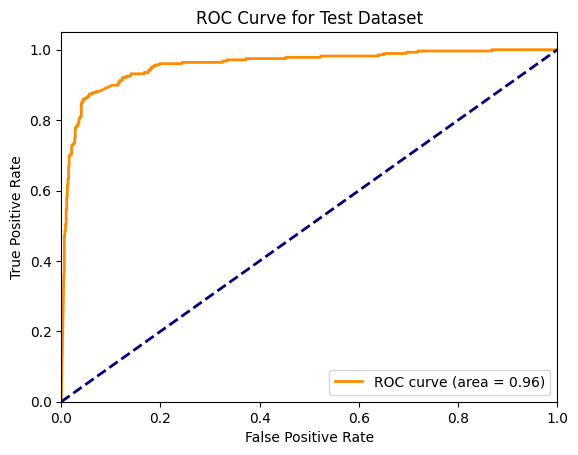

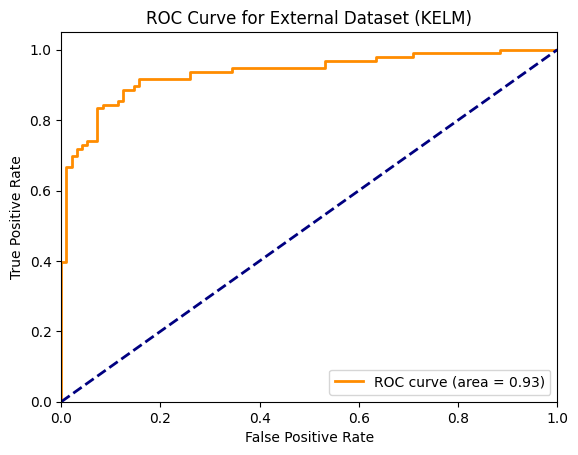

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_probas, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probas)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

# Plot ROC curve for the test dataset
plot_roc_curve(y_test, predicted_probas_test, title='ROC Curve for Test Dataset')

# Plot ROC curve for the external dataset
plot_roc_curve(y_external, predicted_probas_ext, title='ROC Curve for External Dataset (KELM)')


In [5]:
import pandas as pd

# Example saving for the test dataset
df_test = pd.DataFrame({
    'False Positive Rate': fpr_test,
    'True Positive Rate': tpr_test,
    'ROC AUC': [roc_auc_test] * len(fpr_test)  # AUC is constant across the curve
})
df_test.to_csv('ESM-480_test_dataset_roc_values.csv', index=False)

# Example saving for the external dataset
df_ext = pd.DataFrame({
    'False Positive Rate': fpr_ext,
    'True Positive Rate': tpr_ext,
    'ROC AUC': [roc_auc_ext] * len(fpr_ext)  # AUC is constant across the curve
})
df_ext.to_csv('ESM-480_external_dataset_roc_values.csv', index=False)


NameError: name 'fpr_test' is not defined